# The Propensity Score as a Balancing Score

**Chapter 11, Section 1**

This notebook covers the propensity score theorem: how a single scalar summarizes all confounders.

## Table of Contents
1. [Intuition](#intuition) - Dimension reduction for matching
2. [Formal Treatment](#formal) - Balancing score theorem
3. [Numeric Demonstration](#numeric) - Growth mindset study
4. [Implementation](#implementation) - Estimating propensity scores
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *
from sklearn.linear_model import LogisticRegression

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### The Curse of Dimensionality Problem

Matching on multiple covariates becomes difficult:
- 2 continuous variables: Find 2D neighbors
- 10 continuous variables: Find 10D neighbors (very hard)
- 50 variables: Essentially impossible

### The Propensity Score Solution

**Key insight** (Rosenbaum & Rubin, 1983):

> Matching on the **propensity score** is sufficient to remove confounding, regardless of how many covariates there are.

$$e(X) = P(T=1 | X)$$

The propensity score is the probability of receiving treatment given covariates.

### Why This Works

**Balancing property**: Within strata of $e(X)$, treated and control groups have the same covariate distribution:

$$X \perp T \mid e(X)$$

If two units (one treated, one control) have the same propensity score, their covariates are "balanced" on average.

---

In [2]:
# Load learning mindset data
mindset = load_facure_data("learning_mindset.csv")

print(f"Data: {len(mindset)} students")
print(f"Treatment (intervention): {mindset['intervention'].mean():.1%} received intervention")
print(f"\nOutcome: achievement_score")
print(f"\nCovariates:")
print(f"  Individual: success_expect, ethnicity, gender, frst_in_family")
print(f"  School: school_mindset, school_achievement, school_ethnic_minority, school_poverty, school_size")
mindset.head()

Data: 10391 students
Treatment (intervention): 32.6% received intervention

Outcome: achievement_score

Covariates:
  Individual: success_expect, ethnicity, gender, frst_in_family
  School: school_mindset, school_achievement, school_ethnic_minority, school_poverty, school_size


,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
0,76,1,0.2774,6,4,2,1,4,0.3345,0.6486,-1.3109,0.2241,-0.4268
1,76,1,-0.4496,4,12,2,1,4,0.3345,0.6486,-1.3109,0.2241,-0.4268
2,76,1,0.7697,6,4,2,0,4,0.3345,0.6486,-1.3109,0.2241,-0.4268
3,76,1,-0.1218,6,4,2,0,4,0.3345,0.6486,-1.3109,0.2241,-0.4268
4,76,1,1.5261,6,4,1,0,4,0.3345,0.6486,-1.3109,0.2241,-0.4268


In [3]:
# Define covariates for propensity score
covariates = [
    'success_expect', 'ethnicity', 'gender', 'frst_in_family',
    'school_mindset', 'school_achievement', 'school_ethnic_minority',
    'school_poverty', 'school_size'
]

# Check balance before any adjustment
print("COVARIATE BALANCE (before adjustment):")
print("=" * 70)
print(f"\n{'Covariate':<25} {'Control Mean':<15} {'Treated Mean':<15} {'Diff'}")
print("-" * 70)

for cov in covariates:
    control_mean = mindset[mindset['intervention'] == 0][cov].mean()
    treated_mean = mindset[mindset['intervention'] == 1][cov].mean()
    diff = treated_mean - control_mean
    print(f"{cov:<25} {control_mean:<15.3f} {treated_mean:<15.3f} {diff:+.3f}")

COVARIATE BALANCE (before adjustment):

Covariate                 Control Mean    Treated Mean    Diff
----------------------------------------------------------------------
success_expect            5.222           5.363           +0.141
ethnicity                 5.241           5.186           -0.055
gender                    1.499           1.472           -0.027
frst_in_family            0.646           0.600           -0.046
school_mindset            -0.009          -0.105          -0.095
school_achievement        0.037           0.092           +0.056
school_ethnic_minority    -0.088          -0.092          -0.005
school_poverty            -0.038          -0.062          -0.024
school_size               -0.050          0.024           +0.074


---

## Formal Treatment

### Definition

**Definition** (Propensity Score):

$$e(X) = P(T=1 | X)$$

The propensity score is the conditional probability of treatment given observed covariates.

### Balancing Score Theorem

**Theorem** (Rosenbaum & Rubin, 1983):

If $(Y(0), Y(1)) \perp T | X$, then $(Y(0), Y(1)) \perp T | e(X)$.

**Proof**:

We need to show that $P(T=1 | Y(0), Y(1), e(X)) = P(T=1 | e(X))$.

**Step 1**: By law of iterated expectations:
$$P(T=1 | Y(0), Y(1), e(X)) = E[T | Y(0), Y(1), e(X)]$$

**Step 2**: Condition on $X$:
$$= E[E[T | Y(0), Y(1), X] | Y(0), Y(1), e(X)]$$

**Step 3**: By conditional ignorability $(Y(0), Y(1)) \perp T | X$:
$$= E[E[T | X] | Y(0), Y(1), e(X)]$$
$$= E[e(X) | Y(0), Y(1), e(X)]$$

**Step 4**: Since $e(X)$ is a function of $X$:
$$= e(X) = P(T=1 | e(X))$$

Therefore, conditioning on $e(X)$ is sufficient for ignorability. $\square$

### Corollary: Balancing Property

**Corollary**: $X \perp T | e(X)$

Within strata of the propensity score, covariates are balanced between treated and control groups.

---

In [4]:
# Estimate propensity scores using logistic regression
X = mindset[covariates].values
T = mindset['intervention'].values

# Fit logistic regression (high C = no regularization)
ps_model = LogisticRegression(C=1e6, max_iter=1000, solver='lbfgs')
ps_model.fit(X, T)

# Get propensity scores
propensity_scores = ps_model.predict_proba(X)[:, 1]
mindset['ps'] = propensity_scores

print("PROPENSITY SCORE ESTIMATION:")
print("=" * 50)
print(f"Model: Logistic Regression")
print(f"Covariates: {len(covariates)}")
print(f"\nPropensity Score Summary:")
print(f"  Min:  {propensity_scores.min():.4f}")
print(f"  Max:  {propensity_scores.max():.4f}")
print(f"  Mean: {propensity_scores.mean():.4f}")
print(f"  Std:  {propensity_scores.std():.4f}")

PROPENSITY SCORE ESTIMATION:
Model: Logistic Regression
Covariates: 9

Propensity Score Summary:
  Min:  0.1818
  Max:  0.4551
  Mean: 0.3257
  Std:  0.0393


/tmp/ipykernel_1113544/721622166.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([ps_control, ps_treated], labels=['Control', 'Treated'])


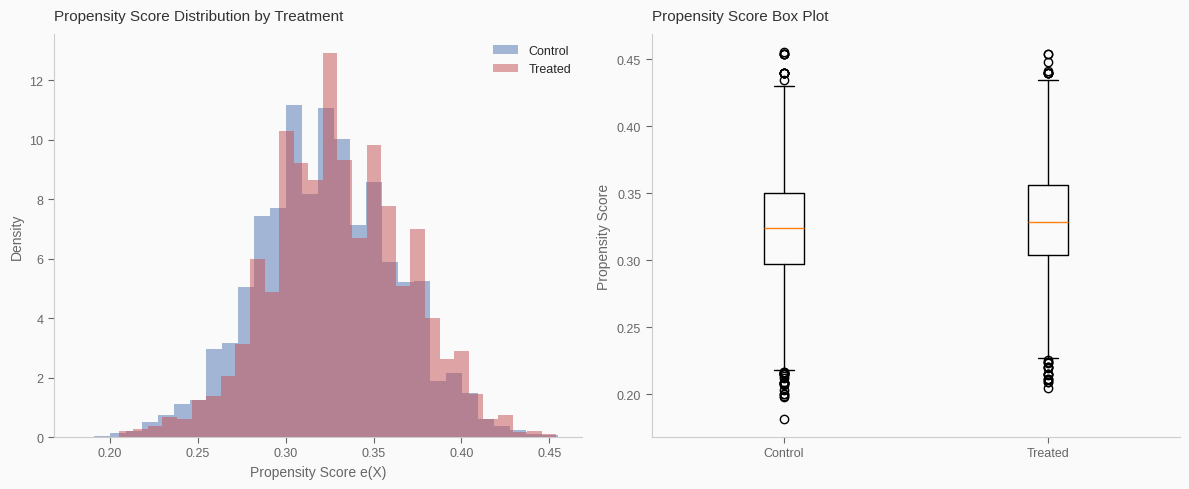


Overlap region: [0.2049, 0.4540]


In [5]:
# Visualize propensity score distributions
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Left: Overlapping histograms
ax = axes[0]
for t, color, label in [(0, COLORS['blue'], 'Control'), (1, COLORS['red'], 'Treated')]:
    subset = mindset[mindset['intervention'] == t]
    ax.hist(subset['ps'], bins=30, alpha=0.5, color=color, label=label, density=True)

set_tufte_title(ax, "Propensity Score Distribution by Treatment")
set_tufte_labels(ax, "Propensity Score e(X)", "Density")
ax.legend(frameon=False)

# Right: Check overlap (common support)
ax = axes[1]
ps_treated = mindset[mindset['intervention'] == 1]['ps']
ps_control = mindset[mindset['intervention'] == 0]['ps']

ax.boxplot([ps_control, ps_treated], labels=['Control', 'Treated'])
set_tufte_title(ax, "Propensity Score Box Plot")
set_tufte_labels(ax, "", "Propensity Score")

plt.tight_layout()
plt.show()

# Check overlap
overlap_min = max(ps_treated.min(), ps_control.min())
overlap_max = min(ps_treated.max(), ps_control.max())
print(f"\nOverlap region: [{overlap_min:.4f}, {overlap_max:.4f}]")

---

## Numeric Demonstration

### Verifying the Balancing Property

In [6]:
# Stratify by propensity score quintiles and check balance
mindset['ps_quintile'] = pd.qcut(mindset['ps'], q=5, labels=[1, 2, 3, 4, 5])

print("BALANCE WITHIN PROPENSITY SCORE STRATA:")
print("=" * 70)

# For each quintile, compute mean difference in one covariate
example_cov = 'school_achievement'
print(f"\nCovariate: {example_cov}")
print(f"{'Quintile':<10} {'Control Mean':<15} {'Treated Mean':<15} {'Difference'}")
print("-" * 60)

for q in [1, 2, 3, 4, 5]:
    stratum = mindset[mindset['ps_quintile'] == q]
    control_mean = stratum[stratum['intervention'] == 0][example_cov].mean()
    treated_mean = stratum[stratum['intervention'] == 1][example_cov].mean()
    diff = treated_mean - control_mean
    print(f"{q:<10} {control_mean:<15.3f} {treated_mean:<15.3f} {diff:+.3f}")

# Overall difference
overall_diff = mindset[mindset['intervention']==1][example_cov].mean() - mindset[mindset['intervention']==0][example_cov].mean()
print(f"{'Overall':<10} {'':<15} {'':<15} {overall_diff:+.3f}")
print(f"\nWithin strata, balance is much better than overall!")

BALANCE WITHIN PROPENSITY SCORE STRATA:

Covariate: school_achievement
Quintile   Control Mean    Treated Mean    Difference
------------------------------------------------------------
1          -0.399          -0.421          -0.022
2          -0.206          -0.202          +0.003
3          0.089           0.092           +0.003
4          0.278           0.317           +0.040
5          0.510           0.488           -0.022
Overall                                    +0.056

Within strata, balance is much better than overall!


In [7]:
# Compute standardized mean differences (SMD) before and within PS strata
def compute_smd(df, covariate, treatment_col):
    """Compute standardized mean difference."""
    treated = df[df[treatment_col] == 1][covariate]
    control = df[df[treatment_col] == 0][covariate]
    
    pooled_std = np.sqrt((treated.var() + control.var()) / 2)
    if pooled_std == 0:
        return 0
    return (treated.mean() - control.mean()) / pooled_std

print("\nSTANDARDIZED MEAN DIFFERENCES:")
print("=" * 60)
print(f"{'Covariate':<25} {'Overall SMD':<15} {'Within-Strata SMD'}")
print("-" * 60)

for cov in covariates:
    # Overall SMD
    overall_smd = compute_smd(mindset, cov, 'intervention')
    
    # Within-strata SMD (average across strata)
    within_smds = []
    for q in [1, 2, 3, 4, 5]:
        stratum = mindset[mindset['ps_quintile'] == q]
        if len(stratum[stratum['intervention']==0]) > 0 and len(stratum[stratum['intervention']==1]) > 0:
            within_smds.append(compute_smd(stratum, cov, 'intervention'))
    avg_within_smd = np.mean(np.abs(within_smds)) if within_smds else 0
    
    print(f"{cov:<25} {overall_smd:+.3f} ({abs(overall_smd):<.3f}) {avg_within_smd:.3f}")

print(f"\nSMD < 0.1 is considered good balance.")


STANDARDIZED MEAN DIFFERENCES:
Covariate                 Overall SMD     Within-Strata SMD
------------------------------------------------------------
success_expect            +0.127 (0.127) 0.017
ethnicity                 -0.014 (0.014) 0.030
gender                    -0.054 (0.054) 0.035
frst_in_family            -0.096 (0.096) 0.031
school_mindset            -0.098 (0.098) 0.021
school_achievement        +0.060 (0.060) 0.021
school_ethnic_minority    -0.005 (0.005) 0.034
school_poverty            -0.025 (0.025) 0.029
school_size               +0.073 (0.073) 0.031

SMD < 0.1 is considered good balance.


---

## Implementation

### Simple Stratification Estimator

In [8]:
# Stratification estimator using propensity score quintiles
def stratification_ate(df, outcome_col, treatment_col, strata_col):
    """
    Estimate ATE using stratification on propensity score.
    """
    strata_effects = []
    
    for stratum in df[strata_col].unique():
        stratum_data = df[df[strata_col] == stratum]
        treated = stratum_data[stratum_data[treatment_col] == 1]
        control = stratum_data[stratum_data[treatment_col] == 0]
        
        if len(treated) > 0 and len(control) > 0:
            effect = treated[outcome_col].mean() - control[outcome_col].mean()
            weight = len(stratum_data) / len(df)
            strata_effects.append({
                'stratum': stratum,
                'n': len(stratum_data),
                'n_treated': len(treated),
                'n_control': len(control),
                'effect': effect,
                'weight': weight
            })
    
    strata_df = pd.DataFrame(strata_effects)
    ate = (strata_df['effect'] * strata_df['weight']).sum()
    
    return ate, strata_df

ate_strat, strata_details = stratification_ate(mindset, 'achievement_score', 'intervention', 'ps_quintile')

print("STRATIFICATION ESTIMATOR:")
print("=" * 60)
print(f"\nStrata details:")
print(strata_details.to_string(index=False))
print(f"\nATE (stratification): {ate_strat:.4f}")

STRATIFICATION ESTIMATOR:

Strata details:
 stratum    n  n_treated  n_control  effect  weight
       2 2078        651       1427  0.3500  0.2000
       1 2079        534       1545  0.2861  0.2001
       3 2078        711       1367  0.4675  0.2000
       4 2078        717       1361  0.4064  0.2000
       5 2078        771       1307  0.4887  0.2000

ATE (stratification): 0.3997


In [9]:
# Compare to naive and regression estimates
print("\nCOMPARISON OF ESTIMATES:")
print("=" * 60)

# Naive
naive = mindset[mindset['intervention']==1]['achievement_score'].mean() - mindset[mindset['intervention']==0]['achievement_score'].mean()
print(f"Naive (no adjustment): {naive:.4f}")

# Regression
formula = 'achievement_score ~ intervention + ' + ' + '.join(covariates)
reg_model = smf.ols(formula, data=mindset).fit()
print(f"Regression adjusted:   {reg_model.params['intervention']:.4f}")

# Stratification
print(f"PS Stratification:     {ate_strat:.4f}")


COMPARISON OF ESTIMATES:
Naive (no adjustment): 0.4723
Regression adjusted:   0.3986
PS Stratification:     0.3997


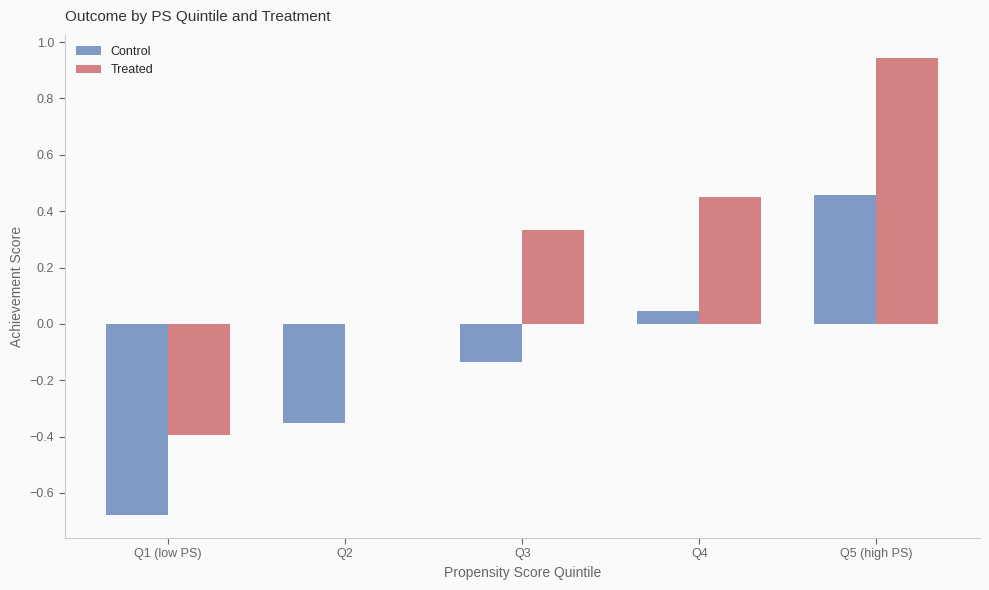

Within each quintile, we compare treated vs control.
This removes confounding because PS balances covariates.


In [10]:
# Visualize the propensity score stratification
fig, ax = create_tufte_figure(figsize=(10, 6))

quintile_means = strata_details.set_index('stratum')
x = np.arange(len(quintile_means))
width = 0.35

# Get outcome means by quintile and treatment
treated_means = []
control_means = []
for q in [1, 2, 3, 4, 5]:
    stratum = mindset[mindset['ps_quintile'] == q]
    treated_means.append(stratum[stratum['intervention']==1]['achievement_score'].mean())
    control_means.append(stratum[stratum['intervention']==0]['achievement_score'].mean())

ax.bar(x - width/2, control_means, width, label='Control', color=COLORS['blue'], alpha=0.7)
ax.bar(x + width/2, treated_means, width, label='Treated', color=COLORS['red'], alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(['Q1 (low PS)', 'Q2', 'Q3', 'Q4', 'Q5 (high PS)'])
set_tufte_title(ax, "Outcome by PS Quintile and Treatment")
set_tufte_labels(ax, "Propensity Score Quintile", "Achievement Score")
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

print("Within each quintile, we compare treated vs control.")
print("This removes confounding because PS balances covariates.")

---

## Production Implementation

This method is implemented in the `causal_inference_mastery` library:

```python
from causal_inference.observational.propensity import (
    estimate_propensity_score,
    PropensityScoreResult
)
from causal_inference.observational.ipw import (
    ipw_ate,
    ipw_att,
    hajek_estimator
)

# Estimate propensity scores
ps_result = estimate_propensity_score(
    treatment=data['intervention'],
    covariates=data[covariates],
    model='logistic',  # or 'gbm', 'random_forest'
    cross_fit=True,
    n_folds=5
)
print(f"PS range: [{ps_result.scores.min():.4f}, {ps_result.scores.max():.4f}]")

# IPW estimator (Hajek for stability)
ate_result = hajek_estimator(
    outcome=data['achievement_score'],
    treatment=data['intervention'],
    propensity_scores=ps_result.scores
)
print(f"ATE (Hajek): {ate_result.ate:.4f}")
print(f"SE: {ate_result.se:.4f}")

# Trimming extreme weights
from causal_inference.observational.trimming import trim_propensity_scores
ps_trimmed = trim_propensity_scores(
    ps_result.scores,
    lower=0.05,
    upper=0.95
)
```

**Key differences from notebook demo**:
- Production code implements multiple PS estimation methods (logistic, GBM, RF)
- Cross-fitting to avoid overfitting in PS estimation
- Hajek (normalized) estimator for variance reduction
- Automatic trimming and diagnostics for extreme weights
- Balance checks via standardized mean differences
- Cross-validated with Julia implementation

**See also**: `causal_inference_mastery/src/causal_inference/observational/`

---

## Interview Appendix

### Practice Questions

**Q1: Why is the propensity score a balancing score?**

<details>
<summary>Solution</summary>

A **balancing score** $b(X)$ satisfies: $X \perp T | b(X)$.

**Why propensity score is balancing**:

For any covariate $X_k$, within strata of $e(X)$:

$$E[X_k | T=1, e(X)] = E[X_k | T=0, e(X)]$$

**Intuition**: Among units with the same propensity score, treated and control groups are balanced on all covariates (on average).

**Proof sketch**:
1. $e(X) = P(T=1|X)$ is the conditional probability
2. Within any stratum of $e(X)$, the probability of treatment is constant
3. If treatment probability is constant conditional on $e(X)$, then treatment is essentially random within strata
4. Random treatment implies balanced covariates

**Key insight**: The propensity score is the **coarsest** balancing score - it summarizes all the information in $X$ that's relevant for treatment assignment.

</details>

**Q2: What assumptions are needed for propensity score methods?**

<details>
<summary>Solution</summary>

**Assumption 1: Conditional Ignorability (Unconfoundedness)**

$$\{Y(0), Y(1)\} \perp T | X$$

Treatment is random conditional on observed covariates. **Cannot be tested** - requires subject matter knowledge.

**Assumption 2: Positivity (Overlap/Common Support)**

$$0 < e(X) < 1 \quad \text{for all } X$$

Every unit has a chance of being treated or control. **Can be checked** by examining propensity score distributions.

**Assumption 3: SUTVA**
- No interference between units
- No hidden versions of treatment

**Assumption 4: Correct PS Model**

The propensity score model should be correctly specified. Unlike outcome regression, we only need the PS model to balance covariates, not predict perfectly.

**When PS methods fail**:
1. Unmeasured confounding (violates A1)
2. No overlap (violates A2)
3. Severe PS model misspecification

</details>

**Q3: How does propensity score solve the curse of dimensionality in matching?**

<details>
<summary>Solution</summary>

**The Problem**:
- Matching on $p$ covariates becomes infeasible as $p$ increases
- In high dimensions, all points are approximately equidistant
- Finding "close" matches becomes impossible

**The PS Solution**:
- Instead of matching on $p$ covariates, match on 1 scalar: $e(X)$
- Propensity score summarizes all covariate information relevant for treatment
- Matching on $e(X)$ balances all covariates (balancing score theorem)

**Why this works**:

The theorem proves that:
$$(Y(0), Y(1)) \perp T | X \implies (Y(0), Y(1)) \perp T | e(X)$$

So we lose nothing (in terms of identification) by conditioning on the scalar $e(X)$ instead of the full vector $X$.

**Trade-off**:
- PS estimation introduces model dependence
- If PS model is wrong, balance may be poor
- Solution: Check balance after PS estimation

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 11.

[^2]: Rosenbaum, P. R., & Rubin, D. B. (1983). The central role of the propensity score in observational studies for causal effects. *Biometrika*, 70(1), 41-55.

[^3]: Angrist, J. D., & Pischke, J.-S. (2009). *Mostly Harmless Econometrics*, Section 3.3.

[^4]: Cross-reference: IPTW in `11_propensity_score/02_iptw.ipynb`